In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import plotly.express as px
import random
import json
from sklearn.preprocessing import MinMaxScaler

sys.path.append(os.path.abspath('../src/'))
from ModelSelection import *
from ActivationFunctions import *
from NeuralNetwork import *
from MyUtils import *

In [2]:
tr_df = pd.read_csv('../data/monks_csv/monks_tr_3.csv', index_col=0)
len_training = len(tr_df)
val_df = pd.read_csv('../data/monks_csv/monks_ts_3.csv', index_col=0) # test in realtà ma va be
len_validation = len(val_df)
len_dataset = len_training + len_validation
val_df.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,input_3,input_4,input_5,input_6,output_1
173,2,1,2,1,3,2,1
91,1,2,2,3,2,2,1
105,1,3,1,2,1,2,0
431,3,3,2,3,4,2,0
389,3,3,1,1,3,2,1


In [3]:
def OHE(df):
    OHE = pd.get_dummies(df, columns=['input_'+str(i) for i in range(1, 7)])
    OHE = OHE.set_axis(['output_1'] + ['input_' + str(i) for i in range(1, len(OHE.columns))], axis=1)
    cols = OHE.columns.tolist()
    cols = cols[1:] + cols[:1]
    OHE = OHE[cols]
    return OHE

In [4]:
tr_df_OHE = OHE(tr_df)
tr_df_OHE.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,input_10,input_11,input_12,input_13,input_14,input_15,input_16,input_17,output_1
93,False,False,True,True,False,False,True,False,False,False,True,False,False,False,True,False,True,0
16,True,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,True,1
17,True,False,False,False,True,False,True,False,True,False,False,False,False,True,False,True,False,1
95,False,False,True,True,False,False,False,True,False,True,False,False,False,True,False,False,True,1
35,True,False,False,False,False,True,True,False,True,False,False,False,True,False,False,True,False,0


In [5]:
val_df_OHE = OHE(val_df)
val_df_OHE.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,input_10,input_11,input_12,input_13,input_14,input_15,input_16,input_17,output_1
173,False,True,False,True,False,False,False,True,True,False,False,False,False,True,False,False,True,1
91,True,False,False,False,True,False,False,True,False,False,True,False,True,False,False,False,True,1
105,True,False,False,False,False,True,True,False,False,True,False,True,False,False,False,False,True,0
431,False,False,True,False,False,True,False,True,False,False,True,False,False,False,True,False,True,0
389,False,False,True,False,False,True,True,False,True,False,False,False,False,True,False,False,True,1


From monk database:

Attribute information:
1. class: 0, 1 
2. a1:    1, 2, 3
3. a2:    1, 2, 3
4. a3:    1, 2
5. a4:    1, 2, 3
6. a5:    1, 2, 3, 4
7. a6:    1, 2
8. Id:    (A unique symbol for each instance)

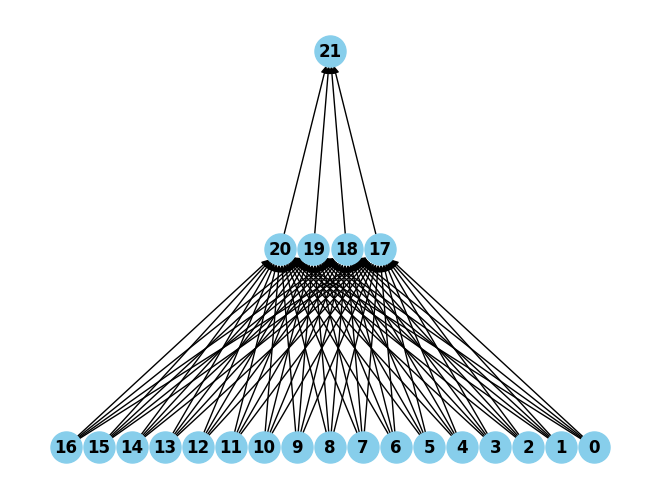

In [6]:
TR_INPUT = len(tr_df_OHE.columns) - 1
TR_OUTPUT = 1
hidden_len = 4
topology = create_stratified_topology([TR_INPUT,hidden_len,TR_OUTPUT], 
                                      [[None,[]]]*TR_INPUT + [['sigmoid', [1]]]*hidden_len + [['sigmoid', [1]]])
NeuralNetwork.display_topology(topology)

In [7]:
MS = ModelSelection('../data/gs_data/monk_3_selection.csv')
training_set = tr_df_OHE.values
hyperparam_grid = {
    'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5],
    'alpha_momentum':[0.3, 0.4, 0.5, 0.6, 0.7],
    'lambda_tikhonov':[0, 0.01, 0.001, 0.0001],
    'batch_size':[int(len(training_set)/15), 1, int(len(training_set)*0.8)], # minibatch, online, batch
    'min_epochs': [80],
    'max_epochs':[600],
    'error_decrease_tolerance':[0.00001],
    'patience':[50],
    'topology': [str(topology)],
}

MS.grid_searchKF(training_set, hyperparam_grid, 5, 4, False)

In [8]:
df = pd.read_csv('../data/gs_data/monk_3_selection.csv')

df.sample(3, random_state=RANDOM_STATE)

df['mean_metrics'] = df['mean_metrics'].apply(lambda x: ast.literal_eval(x))

df = df.sort_values(by=['mean_metrics'], ascending=True)

In [30]:
df.head(10)

,alpha_momentum,batch_size,error_decrease_tolerance,lambda_tikhonov,learning_rate,max_epochs,min_epochs,patience,topology,stats,mean_metrics,variance_metrics
249,0.4,1,0.00001,0.0001,0.5,600,80,50,"{0: ['input_0', None, [], [17, 18, 19, 20]], 1...","{'max_epochs': 600, 'training_set_len': 98, 'm...",[0.06877106846022395],[0.0004069443643033116]
48,0.6,8,0.00001,0.0001,0.4,600,80,50,"{0: ['input_0', None, [], [17, 18, 19, 20]], 1...","{'max_epochs': 600, 'training_set_len': 98, 'm...",[0.06927882164562793],[0.00025274577393038074]
68,0.6,1,0.00001,0.0001,0.4,600,80,50,"{0: ['input_0', None, [], [17, 18, 19, 20]], 1...","{'max_epochs': 600, 'training_set_len': 98, 'm...",[0.0699798654440642],[0.0008415143262094834]
66,0.6,1,0.00001,0.0001,0.2,600,80,50,"{0: ['input_0', None, [], [17, 18, 19, 20]], 1...","{'max_epochs': 600, 'training_set_len': 98, 'm...",[0.07002339196471286],[0.0009820516951231587]
188,0.3,1,0.00001,0.0001,0.4,600,80,50,"{0: ['input_0', None, [], [17, 18, 19, 20]], 1...","{'max_epochs': 600, 'training_set_len': 98, 'm...",[0.07011270521611612],[0.002034468999725124]
129,0.7,1,0.00001,0.0001,0.5,600,80,50,"{0: ['input_0', None, [], [17, 18, 19, 20]], 1...","{'max_epochs': 600, 'training_set_len': 98, 'm...",[0.07168337140895688],[0.002336424727536545]
6,0.5,1,0.00001,0.0001,0.2,600,80,50,"{0: ['input_0', None, [], [17, 18, 19, 20]], 1...","{'max_epochs': 600, 'training_set_len': 98, 'm...",[0.07203121057819734],[0.0025817094662123024]
7,0.5,1,0.00001,0.0001,0.3,600,80,50,"{0: ['input_0', None, [], [17, 18, 19, 20]], 1...","{'max_epochs': 600, 'training_set_len': 98, 'm...",[0.0727794443748452],[0.0008780524486037052]
52,0.6,1,0.00001,0.0000,0.3,600,80,50,"{0: ['input_0', None, [], [17, 18, 19, 20]], 1...","{'max_epochs': 600, 'training_set_len': 98, 'm...",[0.07284215935570174],[0.0016811678471165656]
246,0.4,1,0.00001,0.0001,0.2,600,80,50,"{0: ['input_0', None, [], [17, 18, 19, 20]], 1...","{'max_epochs': 600, 'training_set_len': 98, 'm...",[0.07299970438878747],[0.000600523390402111]


In [31]:
NN = NeuralNetwork(topology, -0.75, 0.75, False, RANDOM_STATE)

In [32]:
training_set = tr_df_OHE.values
validation_set = val_df_OHE.values
metrics = [ErrorFunctions.mean_squared_error, ] #ErrorFunctions.mean_euclidean_error, 

batch_size = 1
max_epochs = 600

error_decrease_tolerance = 0.00001
patience = 10
min_epochs = 80

lambda_tikhonov = 0
alpha_momentum = 0.6
learning_rate = 0.3/batch_size
# beacause of the momentum is used the learning rate needs to be a little less?!?!?

collect_datas = True
collect_datas_batch = False # per il momento. molto costoso!!!! False di default
verbose = True

stats = NN.train(training_set, validation_set, batch_size, max_epochs, error_decrease_tolerance, patience, min_epochs, 
                   learning_rate,0,0, lambda_tikhonov, alpha_momentum, False,metrics, collect_datas, collect_datas_batch, verbose)

starting values:  {'training_set_len': 122, 'minibatch_size': 1, 'max_epochs': 600, 'error_decrease_tolerance': 1e-05, 'patience': 10, 'min_epochs': 80, 'learning_rate': 0.3, 'lambda_tikhonov': 0, 'alpha_momentum': 0.6, 'nesterov': False, 'epochs': 0, 'total_train_time': datetime.timedelta(days=-1, seconds=86399, microseconds=999989), 'mean_epoch_train_time': 0, 'units_weights': {20: [], 19: [], 18: [], 17: [], 21: []}, 'units_weights_batch': {20: [], 19: [], 18: [], 17: [], 21: []}, 'training_mean_squared_error': [], 'validation_mean_squared_error': [], 'training_batch_mean_squared_error': [], 'validation_batch_mean_squared_error': []}
[1/600] tr time: 0:00:00.050451 | mean_squared_error: tr=0.28187151726396825 val=0.29618019874548107 | 
[2/600] tr time: 0:00:00.039169 | mean_squared_error: tr=0.24264971482897205 val=0.2542437570999178 | 
[3/600] tr time: 0:00:00.037556 | mean_squared_error: tr=0.16350268865723255 val=0.16958694468560948 | 
[4/600] tr time: 0:00:00.036393 | mean_squar

In [33]:
tr_predictions = NN.predict_array(training_set[:,:TR_INPUT])
val_predictions = NN.predict_array(validation_set[:,:TR_INPUT])

In [34]:
pd.options.mode.chained_assignment = None
prediction_col = ['prediction_1']#, 'prediction_2', 'prediction_3']
for col in prediction_col:
    tr_df[prediction_col] = np.array([[1] if x > 0.5 else [0] for x in tr_predictions])
    tr_df[col + '_err'] = (tr_df[col] - tr_df['output_' + col[-1]])**2
    

In [35]:
tr_df['prediction_1_err'].max()

1

In [36]:
tr_df.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,input_3,input_4,input_5,input_6,output_1,prediction_1,prediction_1_err
93,3,1,1,3,4,2,0,0,0
16,1,1,2,3,3,2,1,1,0
17,1,2,1,1,3,1,1,1,0
95,3,1,2,2,3,2,1,1,0
35,1,3,1,1,2,1,0,0,0


In [37]:
val_df[prediction_col] = val_predictions
for col in prediction_col:
    val_df[prediction_col] = np.array([[1] if x > 0.5 else [0] for x in val_predictions])
    val_df[col + '_err'] = (val_df[col] - val_df['output_' + col[-1]])**2
    

In [38]:
val_df.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,input_3,input_4,input_5,input_6,output_1,prediction_1,prediction_1_err
173,2,1,2,1,3,2,1,1,0
91,1,2,2,3,2,2,1,1,0
105,1,3,1,2,1,2,0,0,0
431,3,3,2,3,4,2,0,0,0
389,3,3,1,1,3,2,1,1,0


In [39]:
print('training accuracy =', (tr_df['output_1'] == tr_df['prediction_1']).sum() / len(tr_df))
print('validation accuracy =', (val_df['output_1'] == val_df['prediction_1']).sum() / len(val_df))

training accuracy = 0.9918032786885246
validation accuracy = 0.9375


In [40]:
print('misclassified =', (tr_df['output_1'] != tr_df['prediction_1']).sum(), 'su', len(tr_df))
print('misclassified =', (val_df['output_1'] != val_df['prediction_1']).sum(), 'su', len(val_df))

misclassified = 1 su 122
misclassified = 27 su 432


In [41]:
for key in list(stats.keys())[:12]:
    print(key, ':', stats[key])

training_set_len : 122
minibatch_size : 1
max_epochs : 600
error_decrease_tolerance : 1e-05
patience : 10
min_epochs : 80
learning_rate : 0.3
lambda_tikhonov : 0
alpha_momentum : 0.6
nesterov : False
epochs : 600
total_train_time : 0:00:20.495558


In [42]:
for met in metrics:
    print('last training ' + met.__name__ + ' :', stats['training_' + met.__name__][-1])
    print('last validation ' + met.__name__ + ' :', stats['training_' + met.__name__][-1])

last training mean_squared_error : 0.008369023495372656
last validation mean_squared_error : 0.008369023495372656


In [43]:
for met in metrics:
    print('last training ' + met.__name__ + ' :', stats['training_' + met.__name__][-1])
    print('last validation ' + met.__name__ + ' :', stats['training_' + met.__name__][-1])

last training mean_squared_error : 0.008369023495372656
last validation mean_squared_error : 0.008369023495372656


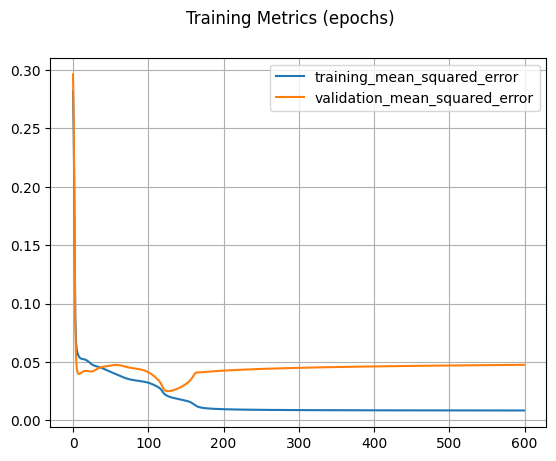

In [44]:
if len(metrics) > 1:
    fig, ax = plt.subplots(1, len(metrics), figsize=(10, 5))
    plt.suptitle('Training Metrics (epochs)')
    for i in range(len(metrics)):
        multy_plot([stats['training_' + metrics[i].__name__], stats['validation_' + metrics[i].__name__]], 
                ['training_' + metrics[i].__name__, 'validation_' + metrics[i].__name__],
                ax=ax[i])
else:
    plt.suptitle('Training Metrics (epochs)')
    multy_plot([stats['training_' + metrics[0].__name__], stats['validation_' + metrics[0].__name__]], 
                ['training_' + metrics[0].__name__, 'validation_' + metrics[0].__name__])

In [45]:

'''plt.suptitle('Training Metrics (epochs)')
for i in range(len(metrics)):
    multy_plot([stats_0['training_' + metrics[i].__name__], stats_0['validation_' + metrics[i].__name__]] + 
               [stats_1['training_' + metrics[i].__name__], stats_1['validation_' + metrics[i].__name__]] +
               [stats_2['training_' + metrics[i].__name__], stats_2['validation_' + metrics[i].__name__]] +
               [stats_3['training_' + metrics[i].__name__], stats_3['validation_' + metrics[i].__name__]],
            ['tr_0.0', 'val_0.0', 'tr_0.25', 'val_0.25', 'tr_0.5', 'val_0.5', 'tr_0.75', 'val_0.75', 'tr_0.95', 'val_0.95',], 
            title='Training Metrics (epochs)')'''

"plt.suptitle('Training Metrics (epochs)')\nfor i in range(len(metrics)):\n    multy_plot([stats_0['training_' + metrics[i].__name__], stats_0['validation_' + metrics[i].__name__]] + \n               [stats_1['training_' + metrics[i].__name__], stats_1['validation_' + metrics[i].__name__]] +\n               [stats_2['training_' + metrics[i].__name__], stats_2['validation_' + metrics[i].__name__]] +\n               [stats_3['training_' + metrics[i].__name__], stats_3['validation_' + metrics[i].__name__]],\n            ['tr_0.0', 'val_0.0', 'tr_0.25', 'val_0.25', 'tr_0.5', 'val_0.5', 'tr_0.75', 'val_0.75', 'tr_0.95', 'val_0.95',], \n            title='Training Metrics (epochs)')"

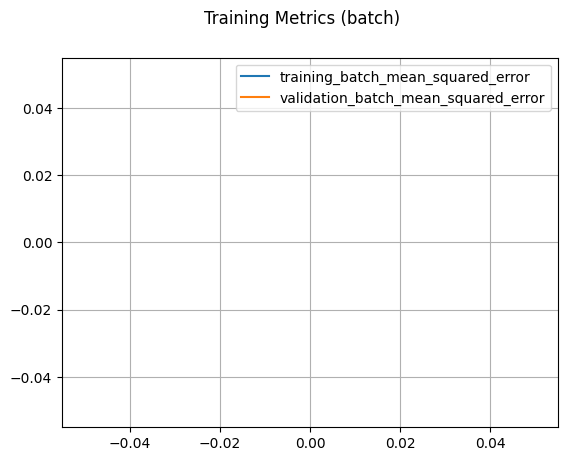

In [46]:
if len(metrics) > 1:
    fig, ax = plt.subplots(1, len(metrics), figsize=(10, 5))
    plt.suptitle('Learning Curve (batch)')
    for i in range(len(metrics)):
        multy_plot([stats['training_batch_' + metrics[i].__name__], stats['validation_batch_' + metrics[i].__name__]], 
                ['training_batch_' + metrics[i].__name__, 'validation_batch_' + metrics[i].__name__],
                ax=ax[i])
    plt.show()
else:
    plt.suptitle('Training Metrics (batch)')
    multy_plot([stats['training_batch_' + metrics[0].__name__], stats['validation_batch_' + metrics[0].__name__]], 
                ['training_batch_' + metrics[0].__name__, 'validation_batch_' + metrics[0].__name__])

In [47]:
'''plt.suptitle('Training Metrics (epochs)')
for i in range(len(metrics)):
    multy_plot([stats_0['training_batch_' + metrics[i].__name__], stats_0['validation_batch_' + metrics[i].__name__]] + 
               [stats_1['training_batch_' + metrics[i].__name__], stats_1['validation_batch_' + metrics[i].__name__]] +
               [stats_2['training_batch_' + metrics[i].__name__], stats_2['validation_batch_' + metrics[i].__name__]] +
               [stats_3['training_batch_' + metrics[i].__name__], stats_3['validation_batch_' + metrics[i].__name__]] + 
               [stats_4['training_batch_' + metrics[i].__name__], stats_4['validation_batch_' + metrics[i].__name__]],
            ['tr_0.0', 'val_0.0', 'tr_0.25', 'val_0.25', 'tr_0.5', 'val_0.5', 'tr_0.75', 'val_0.75', 'tr_0.95', 'val_0.95',], 
            title='Training Metrics (epochs)')'''

"plt.suptitle('Training Metrics (epochs)')\nfor i in range(len(metrics)):\n    multy_plot([stats_0['training_batch_' + metrics[i].__name__], stats_0['validation_batch_' + metrics[i].__name__]] + \n               [stats_1['training_batch_' + metrics[i].__name__], stats_1['validation_batch_' + metrics[i].__name__]] +\n               [stats_2['training_batch_' + metrics[i].__name__], stats_2['validation_batch_' + metrics[i].__name__]] +\n               [stats_3['training_batch_' + metrics[i].__name__], stats_3['validation_batch_' + metrics[i].__name__]] + \n               [stats_4['training_batch_' + metrics[i].__name__], stats_4['validation_batch_' + metrics[i].__name__]],\n            ['tr_0.0', 'val_0.0', 'tr_0.25', 'val_0.25', 'tr_0.5', 'val_0.5', 'tr_0.75', 'val_0.75', 'tr_0.95', 'val_0.95',], \n            title='Training Metrics (epochs)')"

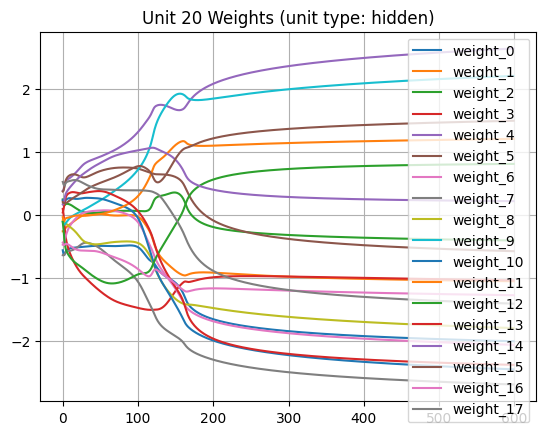

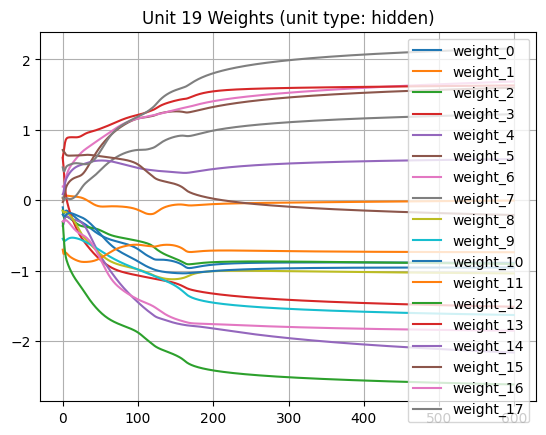

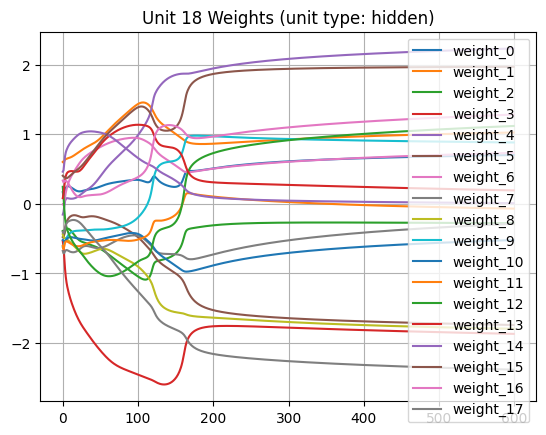

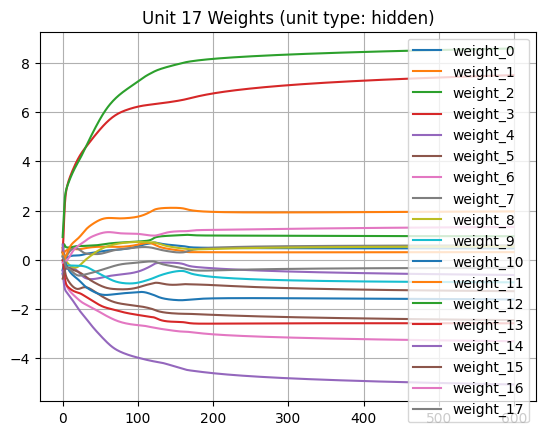

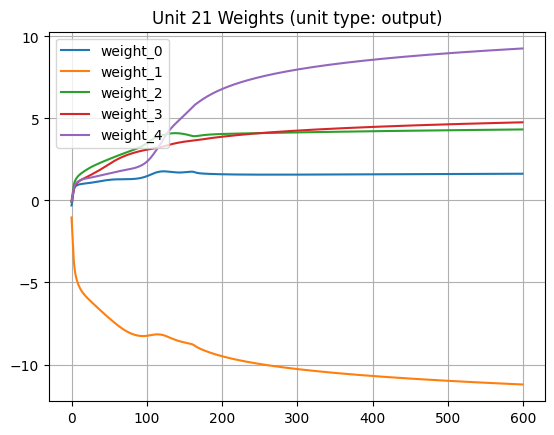

In [48]:
for unit_index in stats['units_weights'].keys():
    vals = np.array(stats['units_weights'][unit_index]).T
    multy_plot(vals, 
               ['weight_' + str(i) for i in range(len(vals))], 
               'Unit ' + str(unit_index) + ' Weights (unit type: ' + NN.neurons[unit_index].type + ')')

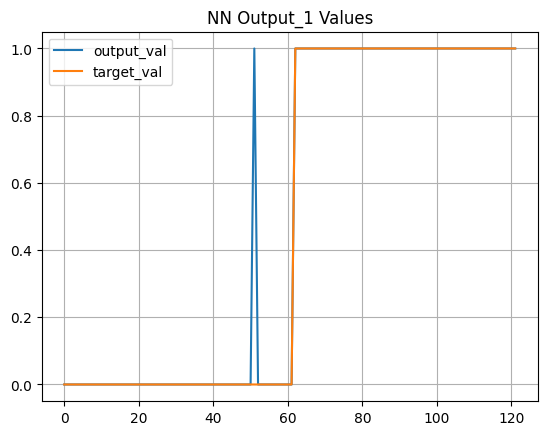

In [49]:
for i in range(TR_OUTPUT):
    sorted_order = training_set[:, TR_INPUT + i].argsort()
    multy_plot([tr_df['prediction_1'].values[sorted_order] , tr_df['output_1'].values[sorted_order]], 
                ['output_val', 'target_val'], 
                'NN Output_' + str(i + 1) +  ' Values')

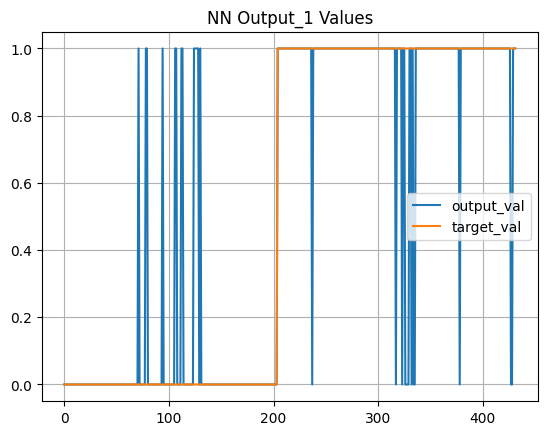

In [50]:
for i in range(TR_OUTPUT):
    sorted_order = validation_set[:, TR_INPUT + i].argsort()
    multy_plot([val_df['prediction_1'].values[sorted_order] , val_df['output_1'].values[sorted_order]], 
                ['output_val', 'target_val'], 
                'NN Output_' + str(i + 1) +  ' Values')